In [1]:
import sys
sys.path.append("../")

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import os
import torch
from utils import *
from collections import defaultdict
import matplotlib.pyplot as plt
import time

#### Experiment Configs

In [4]:
root_path = "/scratch/saksham/data/nerf_llff_data/fern/" # Fern Dataset path on my local
img_wh = (504, 378)
N_importance = 64
N_samples = 64
use_disp = False
chunk = 1024*32*4

In [8]:
from datasets import dataset_dict
from datasets.llff import *

dataset = dataset_dict['llff'](
              root_path,
              split = "val",
              img_wh = img_wh,
              spheric_poses = False,
              val_num = 4
          )

> /scratch/saksham/nerf_pl/datasets/llff.py(261)read_meta()
    259                                           # the nearest depth is at 1/0.75=1.33
    260         breakpoint()
--> 261         self.bounds /= scale_factor
    262         self.poses[..., 3] /= scale_factor
    263 



ipdb>  c


val image is /scratch/saksham/data/nerf_llff_data/fern/images/IMG_4038.JPG


In [9]:
# take a sample from the validation set
index = 0
sample = dataset[index]
rays = sample['rays']
rays.shape

torch.Size([190512, 8])

#### Define Models

In [10]:
from models.nerf import Embedding, NeRF

In [11]:
# Embeds x to (x, sin(2^k x), cos(2^k x), ...) 
embedding_xyz = Embedding(3, 10)
embedding_dir = Embedding(3, 4)

# Encodes input (xyz+dir) to rgb+sigma (not ready to render yet)
nerf_coarse = NeRF()
nerf_fine = NeRF()

ckpt_path = os.path.join(root_path, "checkpoints/fern.ckpt")

In [12]:
load_ckpt(nerf_coarse, ckpt_path, model_name='nerf_coarse')
load_ckpt(nerf_fine, ckpt_path, model_name='nerf_fine')

In [13]:
nerf_coarse.cuda().eval()
nerf_fine.cuda().eval();

In [14]:
models = {'coarse': nerf_coarse, 'fine': nerf_fine}
embeddings = {'xyz': embedding_xyz, 'dir': embedding_dir}

#### Rendering 

In [15]:
# rendering params
N_importance = 64 # number of fine samples per ray
N_samples = 64 # number of coarse samples per ray
use_disp = False # whether to sample in disparity space (inverse depth)
perturb = False # factor to perturb the sampling position on the ray (for coarse model only)
noise_std = 1.0  # factor to perturb the model's prediction of sigma
chunk = 1024*32*4
test_time = True
white_back = dataset.white_back

In [16]:
rays = rays.cuda()

# Doing a batched inference
# for fern, B = 190512
B = rays.shape[0]

In [17]:
# results = f(rays)

In [18]:
# take a batch of rays
rays_now = rays[0:0+chunk] #(131078, 8)

# define the num of rays in batch
N_rays = rays_now.shape[0] # N_rays = 131078

# define center and direction inputs
rays_o, rays_d = rays_now[:, 0:3], rays_now[:, 3:6] # both (N_rays, 3)
near, far = rays_now[:, 6:7], rays_now[:, 7:8] # both (N_rays, 1)

In [20]:
far

tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]], device='cuda:0')

In [89]:
# embed_channel : 27
# encodes direction embedding vector

# (N_rays, embed_dir_channels = 27)
# Input : (N_rays, 3); Output : (N_rays, 27)
dir_embedded = embedding_dir({}.get('view_dir', rays_d)) 

In [90]:
from einops import rearrange, reduce, repeat

rays_o = rearrange(rays_o, 'n1 c -> n1 1 c')
rays_d = rearrange(rays_d, 'n1 c -> n1 1 c')

In [98]:
# Sample depth points
z_steps = torch.linspace(0, 1, N_samples, device=rays.device) # (N_samples)

# use linear sampling in depth space
if not use_disp:
    z_vals = near * (1-z_steps) + far * z_steps # (N_rays, N_samples)
    
z_vals = z_vals.expand(N_rays, N_samples) # (N_rays, N_samples)

In [106]:
# rays_o : (N_rays, 1, 3)
# rays_d : (N_rays, 1, 3)
# z_vals : (N_rays, N_sample)

# o + td
# xyz_coarse : (N_rays, N_samples, 3)
xyz_coarse = rays_o + rays_d * rearrange(z_vals, 'n1 n2 -> n1 n2 1')

Process coarse points on the rays

In [115]:
xyz = xyz_coarse
typ = "coarse"
model = models['coarse']

In [112]:
N_samples_ = xyz.shape[1]
xyz_ = rearrange(xyz, 'n1 n2 c -> (n1 n2) c') # (N_rays*N_samples_, 3)

In [124]:
# Perform model inference to get rgb and raw sigma

B = xyz_.shape[0] #(N_rays*N_sample)
out_chunks = []
if typ=='coarse' and test_time and 'fine' in models:
    for i in range(0, B, chunk):
        
        # Generate positional embeddings
        #  Input : (chunk, 3)
        #  Output : (chunk, 63)
        xyz_embedded = embedding_xyz(xyz_[i:i+chunk])
        
        # restricting the network to predict the volume density σ 
        # as a function of only the location x
        # Generate volume density
        #  Input : (chunk, 63)
        #  Output : [(chunk, 1)]*(B/chunk)
        out_chunks += [model(xyz_embedded, sigma_only=True)]

RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 11.93 GiB total capacity; 7.11 GiB already allocated; 74.00 MiB free; 7.64 GiB reserved in total by PyTorch)

In [120]:
xyz_embedded = embedding_xyz(xyz_[0:0+chunk])

In [122]:
model(xyz_embedded, sigma_only=True).shape

torch.Size([131072, 1])

In [1]:
depth_pred

NameError: name 'depth_pred' is not defined

PSNR 24.57001495361328


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


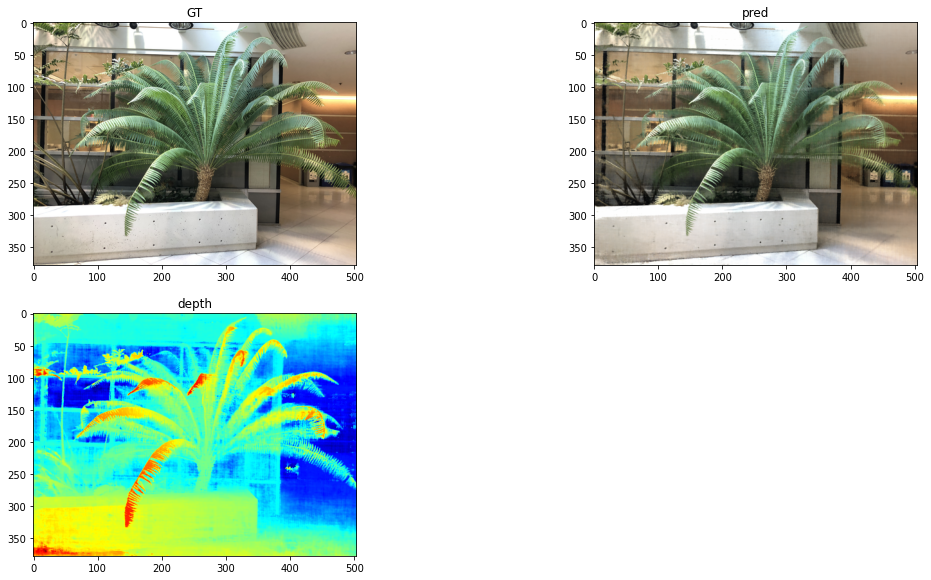

In [22]:
import metrics

img_gt = sample['rgbs'].view(img_wh[1], img_wh[0], 3)
img_pred = results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
alpha_pred = results['opacity_fine'].view(img_wh[1], img_wh[0]).cpu().numpy()
depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])

print('PSNR', metrics.psnr(img_gt, img_pred).item())

plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplot(221)
plt.title('GT')
plt.imshow(img_gt)
plt.subplot(222)
plt.title('pred')
plt.imshow(img_pred)
plt.subplot(223)
plt.title('depth')
plt.imshow(visualize_depth(depth_pred).permute(1,2,0))
plt.show()
    
    
    